# Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pyswarms as ps
import glob
import os
import importlib
import matplotlib.animation as animation
import gzip
import scanpy as sc
import itertools

from scipy.io import mmread
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances, silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyswarms.utils.plotters.formatters import Mesher, Designer
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
from pyswarms.utils.functions import single_obj as fx
from functools import partial
from IPython.display import HTML
from tqdm import tqdm  # For progress bar
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

import src.SI as SI
importlib.reload(SI)

<module 'src.pbmc_SI' from 'd:\\Luca\\Documents\\GitHub\\BDA-project\\notebooks\\src\\pbmc_SI.py'>

# Import data

In [455]:
# 1) Point this to wherever your Cell Ranger output lives:
data_dir = 'data/pbmc10k/filtered_feature_bc_matrix'  # Adjust the path as needed

# 2) Load the data directly into an AnnData object
adata = sc.read_10x_mtx(data_dir, var_names='gene_symbols', cache=True)
adata.var_names_make_unique()

# Check the loaded data
print(adata)

... reading from cache file cache\data-pbmc10k-filtered_feature_bc_matrix-matrix.h5ad
AnnData object with n_obs × n_vars = 10985 × 36601
    var: 'gene_ids', 'feature_types'


In [456]:
# ----------------------------------------
# 1. Load PCA and t-SNE Projections
# ----------------------------------------
pca_proj_downl = pd.read_csv("data/pbmc10k/analysis/pca/10_components/projection.csv")
pca_var_downl = pd.read_csv("data/pbmc10k/analysis/pca/10_components/variance.csv")
barcodes = pca_proj_downl['Barcode'].values

tsne_proj_downl = pd.read_csv("data/pbmc10k/analysis/tsne/2_components/projection.csv")

# ----------------------------------------
# 2. Load Each K-Means Clustering File
# ----------------------------------------
cluster_files_downl = sorted(glob.glob("data/pbmc10k/analysis/clustering/*_clusters/clusters.csv"))
kmeans10_clust_downl = pd.read_csv("data/pbmc10k/analysis/clustering/kmeans_10_clusters/clusters.csv")

In [457]:
print(pca_proj_downl.shape)
pca_proj_downl.head()

(10985, 11)


,Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,AAACCCAGTATATGGA-1,-26.557559,43.616249,-5.920331,-0.437746,-0.684416,-1.070254,7.733377,-3.695116,0.180773,-1.931261
1,AAACCCAGTATCGTAC-1,2.446631,12.503169,9.143050,9.718873,-12.255868,-10.613059,17.103341,-0.873115,-1.452727,4.053146
2,AAACCCAGTCGGTGAA-1,-17.492857,-3.720638,-4.075000,4.693626,-0.223228,-2.966088,2.342027,3.268955,-1.077013,-4.942833
3,AAACCCAGTTAGAAAC-1,33.200922,1.940326,2.890780,3.308408,1.351145,0.437567,-1.220305,6.342324,-0.523541,-0.669859
4,AAACCCAGTTATCTTC-1,-11.462730,15.112253,-44.266984,-10.708478,10.581556,0.123756,-9.832545,1.948709,-4.145212,13.472980


In [458]:
print(tsne_proj_downl.shape)
tsne_proj_downl.head()

(10985, 3)


,Barcode,TSNE-1,TSNE-2
0,AAACCCAGTATATGGA-1,-45.109948,-18.605584
1,AAACCCAGTATCGTAC-1,8.243309,15.607494
2,AAACCCAGTCGGTGAA-1,-10.061613,-10.863419
3,AAACCCAGTTAGAAAC-1,20.417582,-4.917668
4,AAACCCAGTTATCTTC-1,-32.346937,-27.573911


In [459]:
print(kmeans10_clust_downl.shape)
kmeans10_clust_downl.head()

(10985, 2)


,Barcode,Cluster
0,AAACCCAGTATATGGA-1,8
1,AAACCCAGTATCGTAC-1,1
2,AAACCCAGTCGGTGAA-1,3
3,AAACCCAGTTAGAAAC-1,2
4,AAACCCAGTTATCTTC-1,6


# Preprocessing

After demultiplexing and alignment with **Cell Ranger (v6.1.0)** to produce the raw UMI count matrix (run with `--expect-cells=10000`), the counts are loaded into R via `Read10X()` and encapsulated in a **Seurat object** (`CreateSeuratObject(counts = ..., min.cells = 3, min.features = 200)`). Standard **QC metrics** (number of genes detected per cell, total UMI counts, and percentage of mitochondrial reads) are computed (with `PercentageFeatureSet(pattern = "^MT-")`) and stored in the object’s metadata; cells with fewer than 200 or more than 2,500 detected genes or >5% mitochondrial content are filtered out.

The filtered data are **normalized** using Seurat’s **LogNormalize** method (`NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)`), which divides each cell’s counts by its total, multiplies by 10,000, and applies a log1p transform. Next, the **2,000 most highly variable genes** are identified with `FindVariableFeatures(selection.method = "vst", nfeatures = 2000)`, modeling the mean–variance relationship to highlight biologically informative features. These genes are then **scaled and centered** (`ScaleData(pbmc, features = VariableFeatures(pbmc))`), so that each gene has mean = 0 and variance = 1 (with optional regression of technical covariates such as percent.mt). Finally, **PCA** is performed on this scaled subset (`RunPCA(pbmc, features = VariableFeatures(pbmc))`), yielding principal components that capture the major axes of variation prior to downstream clustering or visualization.

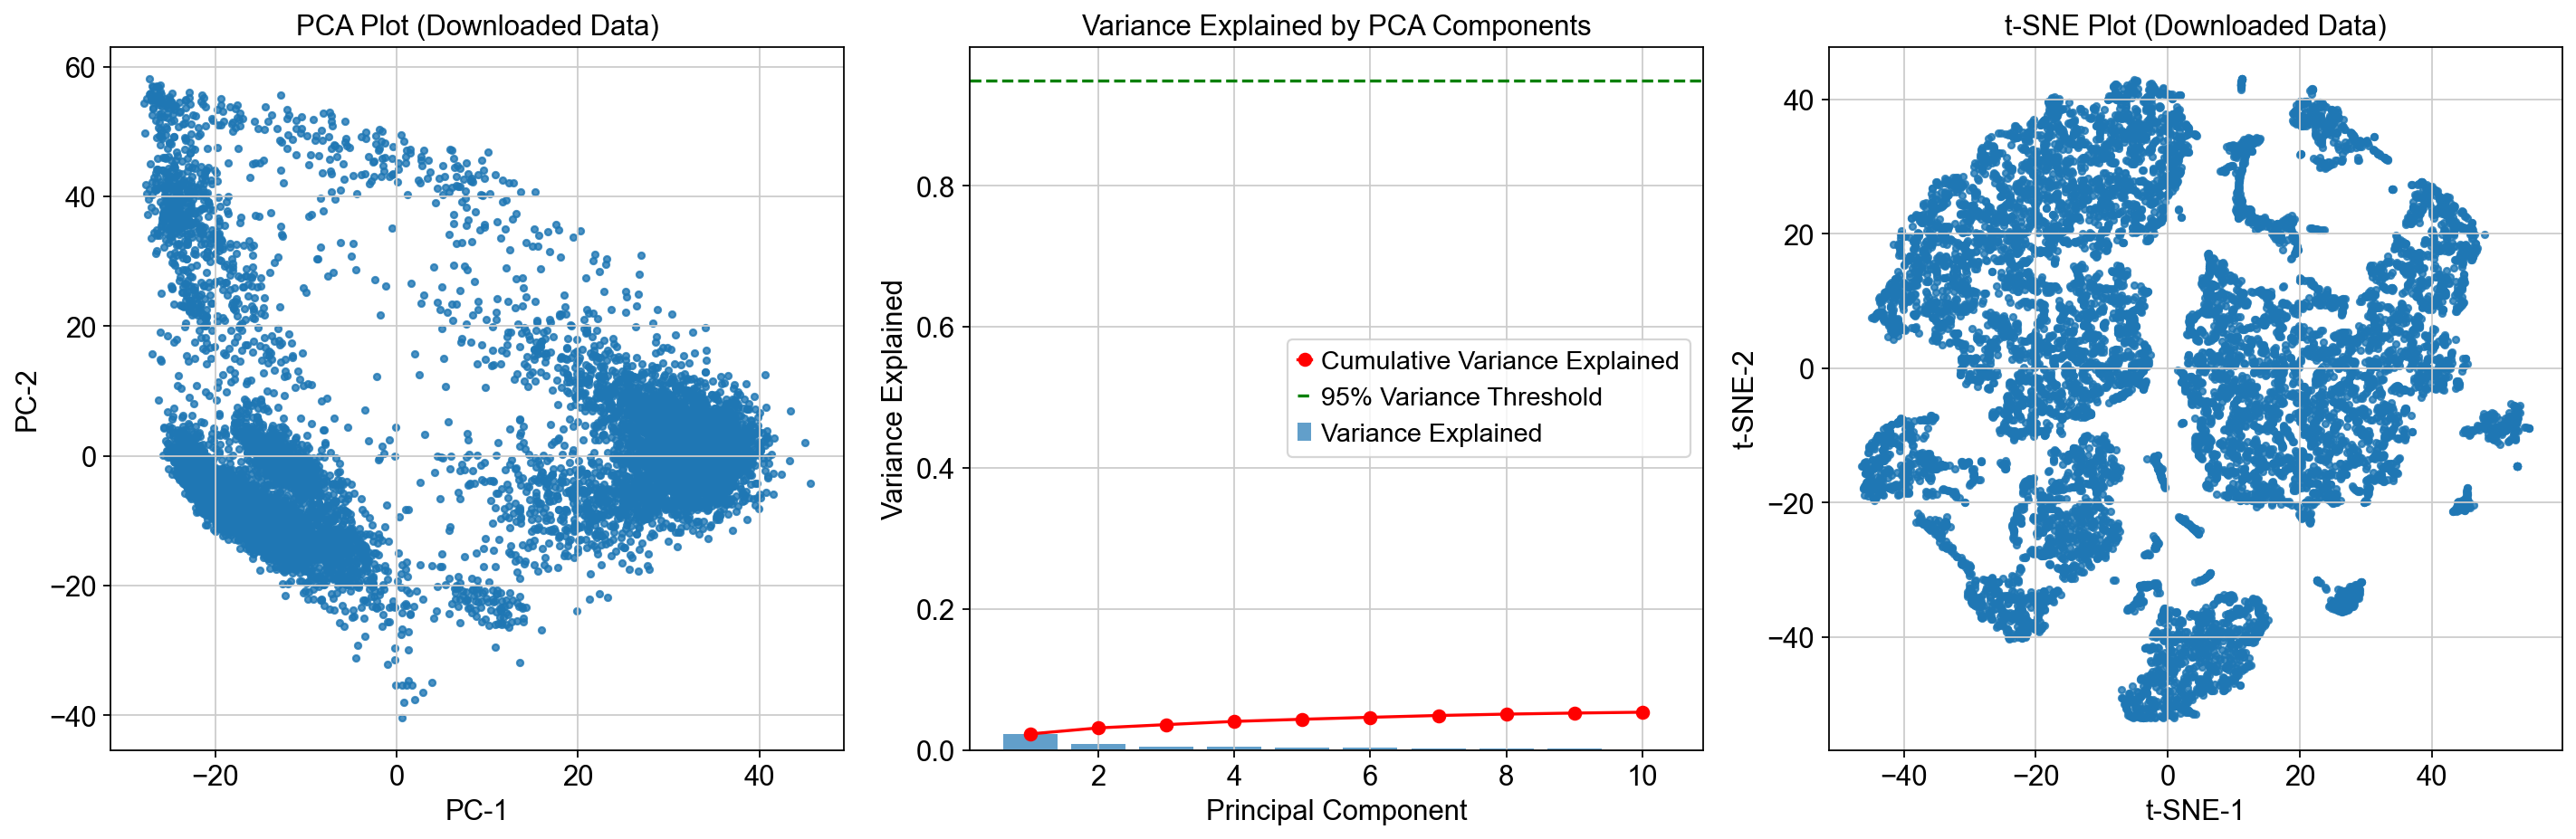

In [460]:
# Create a grid layout for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot downloaded PCA
axes[0].scatter(
    pca_proj_downl[["PC-1"]],  # PC-1
    pca_proj_downl[["PC-2"]],  # PC-2
    s=10, alpha=0.8
)
axes[0].set_title("PCA Plot (Downloaded Data)")
axes[0].set_xlabel("PC-1")
axes[0].set_ylabel("PC-2")
axes[0].grid(True)

# Plot explained variance per PCA component
explained_variance = np.cumsum(pca_var_downl["Proportion.Variance.Explained"])
axes[1].bar(
    range(1, len(pca_var_downl) + 1),
    pca_var_downl["Proportion.Variance.Explained"],
    alpha=0.7, label='Variance Explained'
)
axes[1].plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker='o', color='r', label='Cumulative Variance Explained'
)
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% Variance Threshold')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained')
axes[1].set_title('Variance Explained by PCA Components')
axes[1].legend()
axes[1].grid(True)

# Plot downloaded t-SNE
axes[2].scatter(
    tsne_proj_downl[["TSNE-1"]],  # t-SNE-1
    tsne_proj_downl[["TSNE-2"]],  # t-SNE-2
    s=10, alpha=0.8
)
axes[2].set_title("t-SNE Plot (Downloaded Data)")
axes[2].set_xlabel("t-SNE-1")
axes[2].set_ylabel("t-SNE-2")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Clustering

In [461]:
input_data = pca_proj_downl.drop(columns=["Barcode"])[["PC-1", "PC-2"]].to_numpy()
n_features = input_data.shape[1]
input_data

array([[-26.55755948,  43.6162489 ],
       [  2.44663113,  12.50316887],
       [-17.4928571 ,  -3.72063798],
       ...,
       [ 29.06983067,   5.63542132],
       [-17.20699479,  -7.47370515],
       [ 32.30828208,  -0.68689795]], shape=(10985, 2))

## K-Means

In [462]:
# Define the range of clusters to test
cluster_range = range(2, 11)  # Test from 2 to 10 clusters
best_score = -1
best_n_clusters = None

# Loop through each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(input_data)
    score = silhouette_score(input_data, labels)
    
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {score:.4f}")
    
    # Update the best score and number of clusters
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters}, Best Silhouette Score: {best_score:.4f}")

Number of clusters: 2, Silhouette Score: 0.6722
Number of clusters: 3, Silhouette Score: 0.7344
Number of clusters: 4, Silhouette Score: 0.5833
Number of clusters: 5, Silhouette Score: 0.5413
Number of clusters: 6, Silhouette Score: 0.4316
Number of clusters: 7, Silhouette Score: 0.4775
Number of clusters: 8, Silhouette Score: 0.4625
Number of clusters: 9, Silhouette Score: 0.4564
Number of clusters: 10, Silhouette Score: 0.4554

Best number of clusters: 3, Best Silhouette Score: 0.7344


In [463]:
# Run K-Means clustering
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(input_data)

# Save the clustering results
kmeans_clusters_df = pd.DataFrame({
    "Barcode": barcodes,
    "Cluster": kmeans_labels
})

kmeans_clusters_df.head()

,Barcode,Cluster
0,AAACCCAGTATATGGA-1,2
1,AAACCCAGTATCGTAC-1,0
2,AAACCCAGTCGGTGAA-1,0
3,AAACCCAGTTAGAAAC-1,1
4,AAACCCAGTTATCTTC-1,0


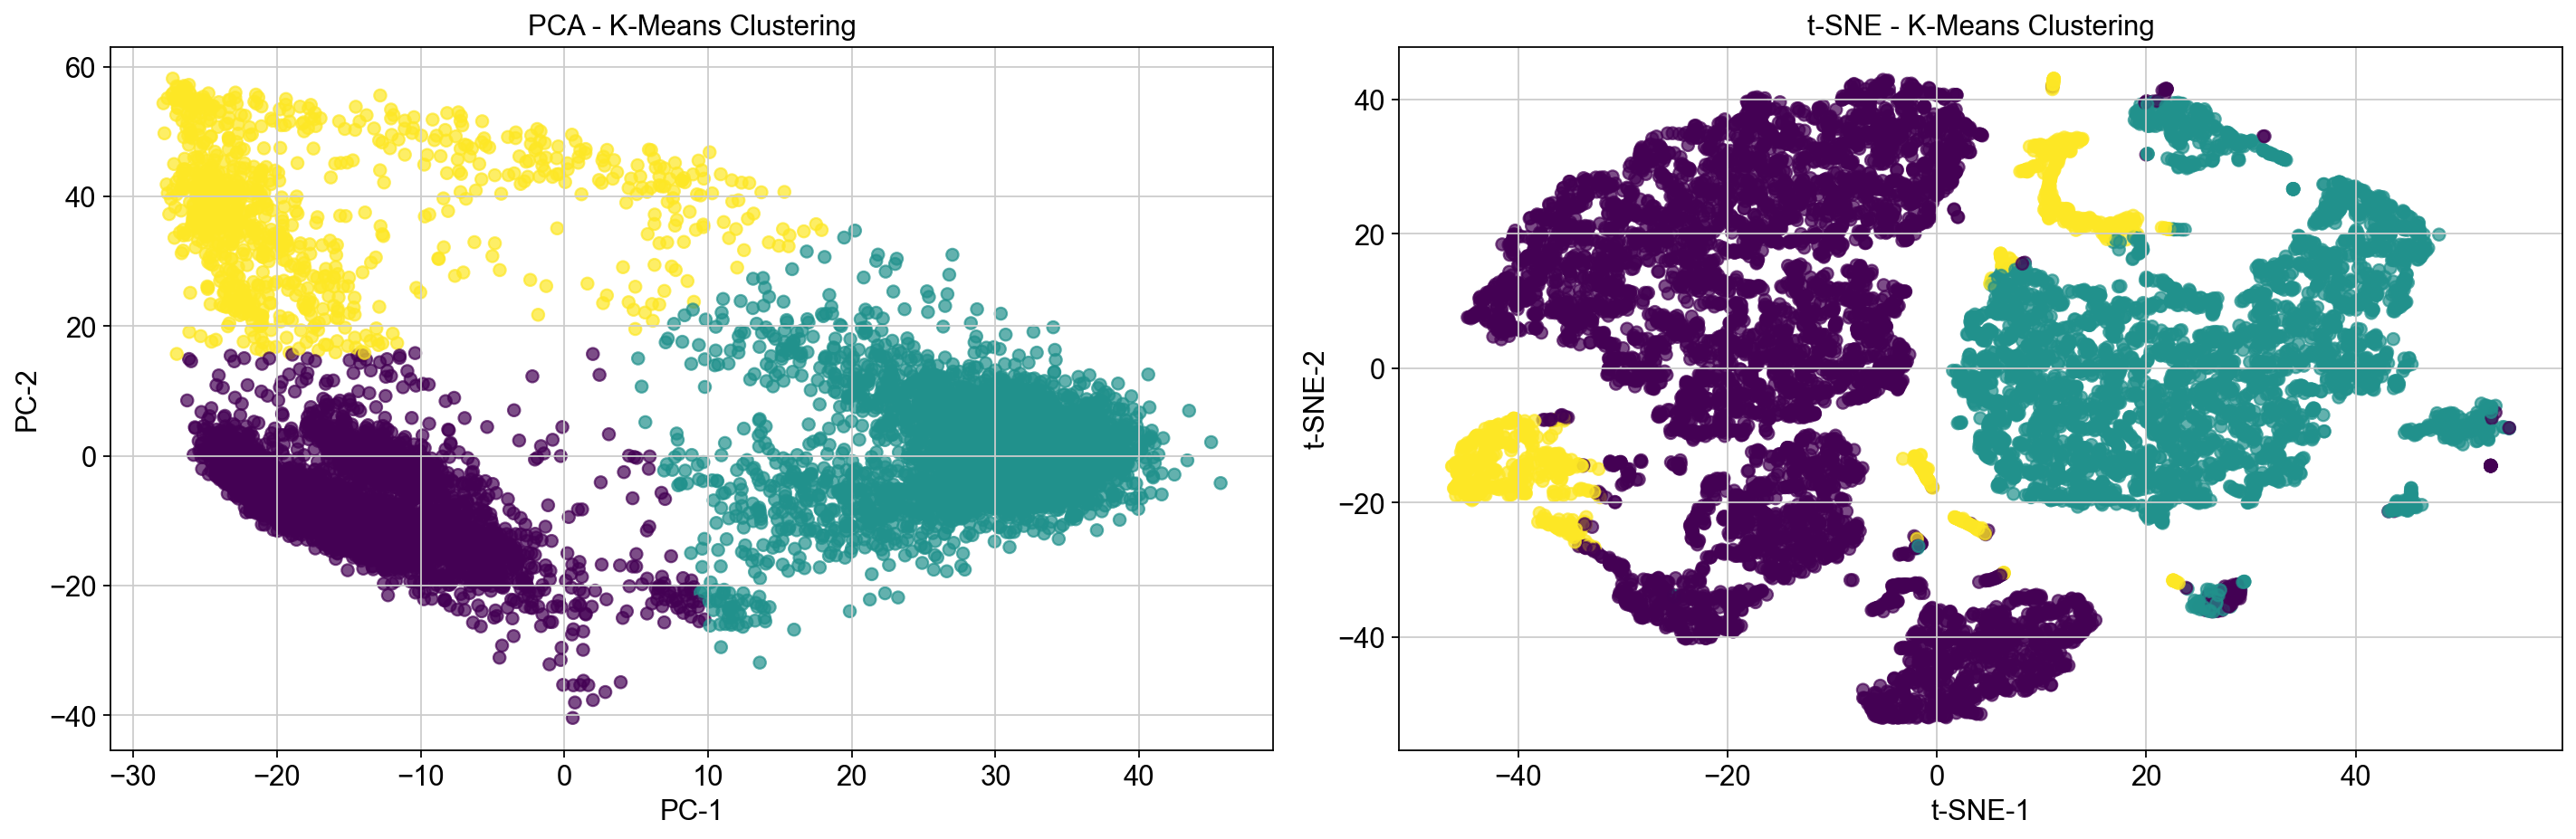

In [464]:
# Create a grid layout for the plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot K-Means Clustering
plt.sca(axes[0])  # Set the current axis to the first subplot
SI.plot_clusters(
    pca_proj_downl.drop(columns=["Barcode"]),
    kmeans_labels,
    title="PCA - K-Means Clustering",
    x_label="PC-1",
    y_label="PC-2"
)

plt.sca(axes[1])

SI.plot_clusters(
    tsne_proj_downl.drop(columns=["Barcode"]),
    kmeans_labels,
    title="t-SNE - K-Means Clustering",
    x_label="t-SNE-1",
    y_label="t-SNE-2",
)

# Adjust layout
plt.tight_layout()
plt.show()

In [465]:
results = pd.DataFrame(columns=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])
results.loc["K-Means"] = SI.calculate_clustering_scores(input_data, kmeans_labels)
results.head()

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means,0.734,0.429,36096.6


## Swarm Intelligence

In [466]:
iters = 100

### PSO

In [467]:
# Define the parameter search space for Bayesian Optimization
param_space = [
    Real(0.1, 2.0, name='c1'),  # Cognitive parameter
    Real(0.1, 2.0, name='c2'),  # Social parameter
    Real(0.1, 1.0, name='w'),   # Inertia weight
    Integer(5, 50, name='n_particles'),  # Number of particles
    Integer(2, 10, name='n_clusters')    # Number of clusters
]

# Define the objective function for Bayesian Optimization
@use_named_args(param_space)
def objective_function(**params):
    options = {'c1': params['c1'], 'c2': params['c2'], 'w': params['w']}
    n_particles = params['n_particles']
    n_clusters = params['n_clusters']
    
    print(f"Testing parameters: c1={params['c1']:.2f}, c2={params['c2']:.2f}, w={params['w']:.2f}, "
          f"n_particles={n_particles}, n_clusters={n_clusters}")
    
    # Run PSO with the given parameters
    pso_cost, pso_centers, pso_labels, _, _, _ = SI.run_pso(
        input_data, n_clusters=n_clusters, iters=100, n_particles=n_particles, options=options, record_history=False
    )

    if len(np.unique(pso_labels)) < 2:
        print("Warning: Only one cluster formed.")
        return 1e6  # Return a large penalty
    
    # Calculate silhouette score
    score = silhouette_score(input_data, pso_labels)
    print(f"Silhouette Score: {score:.4f}")
    
    # Return the negative silhouette score (since Bayesian Optimization minimizes the objective)
    return -score

# Run Bayesian Optimization
print("Starting Bayesian Optimization for PSO parameters...")
result = gp_minimize(
    func=objective_function,  # Objective function
    dimensions=param_space,   # Parameter space
    n_calls=30,               # Number of evaluations
    random_state=42           # For reproducibility
)

# Extract the best parameters and score
best_params = result.x
best_score = -result.fun  # Convert back to positive silhouette score

print(f"\nBest Parameters: c1={best_params[0]:.2f}, c2={best_params[1]:.2f}, w={best_params[2]:.2f}, "
      f"n_particles={best_params[3]}, n_clusters={best_params[4]}")
print(f"Best Silhouette Score: {best_score:.4f}")


Starting Bayesian Optimization for PSO parameters...
Testing parameters: c1=1.61, c2=0.45, w=0.80, n_particles=32, n_clusters=6
Silhouette Score: 0.4766
Testing parameters: c1=0.29, c2=0.97, w=0.40, n_particles=11, n_clusters=7
Silhouette Score: 0.5947
Testing parameters: c1=0.21, c2=1.47, w=0.94, n_particles=5, n_clusters=10
Silhouette Score: 0.3527
Testing parameters: c1=1.27, c2=1.26, w=0.11, n_particles=6, n_clusters=6
Silhouette Score: 0.4585
Testing parameters: c1=0.86, c2=0.19, w=0.98, n_particles=15, n_clusters=3
Silhouette Score: 0.7343
Testing parameters: c1=1.27, c2=0.83, w=0.98, n_particles=26, n_clusters=9
Silhouette Score: 0.4158
Testing parameters: c1=1.39, c2=0.96, w=0.11, n_particles=47, n_clusters=7
Silhouette Score: 0.4372
Testing parameters: c1=0.83, c2=0.13, w=0.31, n_particles=16, n_clusters=7
Silhouette Score: 0.5000
Testing parameters: c1=1.26, c2=1.68, w=0.26, n_particles=23, n_clusters=3
Silhouette Score: 0.7344
Testing parameters: c1=1.54, c2=0.91, w=0.29, n_

In [468]:
# Use the best parameters to run PSO
options = {'c1': best_params[0], 'c2': best_params[1], 'w': best_params[2]}
n_particles = best_params[3]
n_clusters = best_params[4]

pso_cost, pso_centers, pso_labels, pso_pos_history, pso_cost_history, pso_best_centers_history = SI.run_pso(
    input_data, n_clusters=n_clusters, iters=100, n_particles=n_particles, options=options, record_history=True
)

# Save the best results
results.loc["PSO"] = SI.calculate_clustering_scores(input_data, pso_labels)


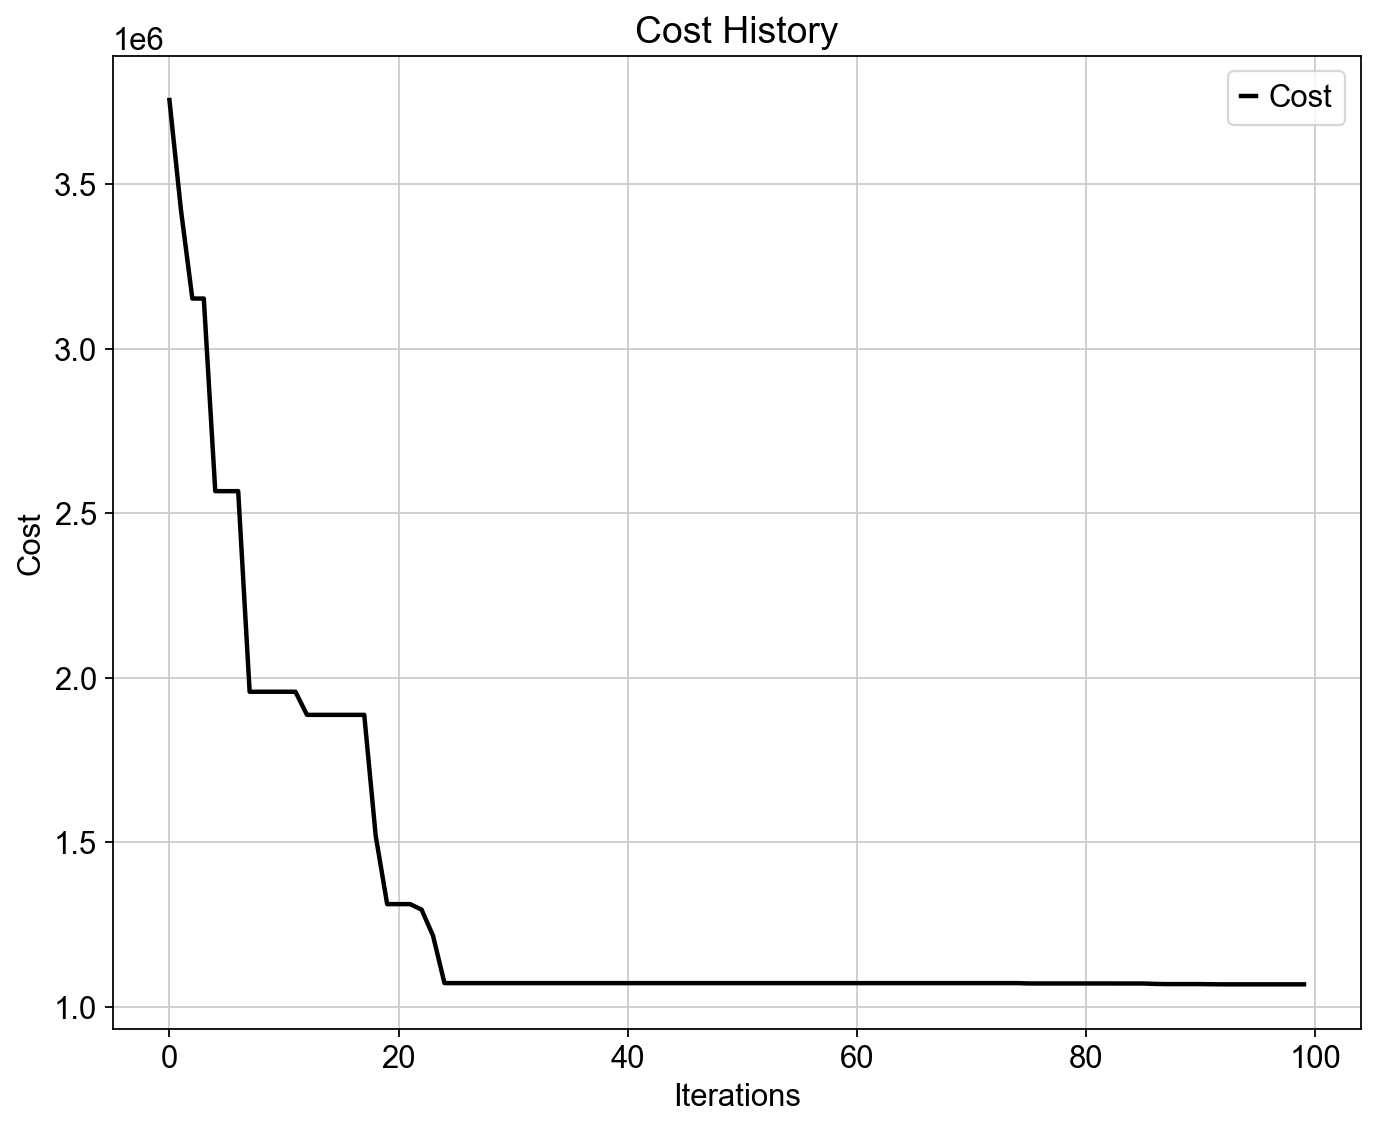

In [469]:
plot_cost_history(cost_history=pso_cost_history)
plt.show()

2025-04-21 23:09:26,298 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-21 23:09:26,299 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


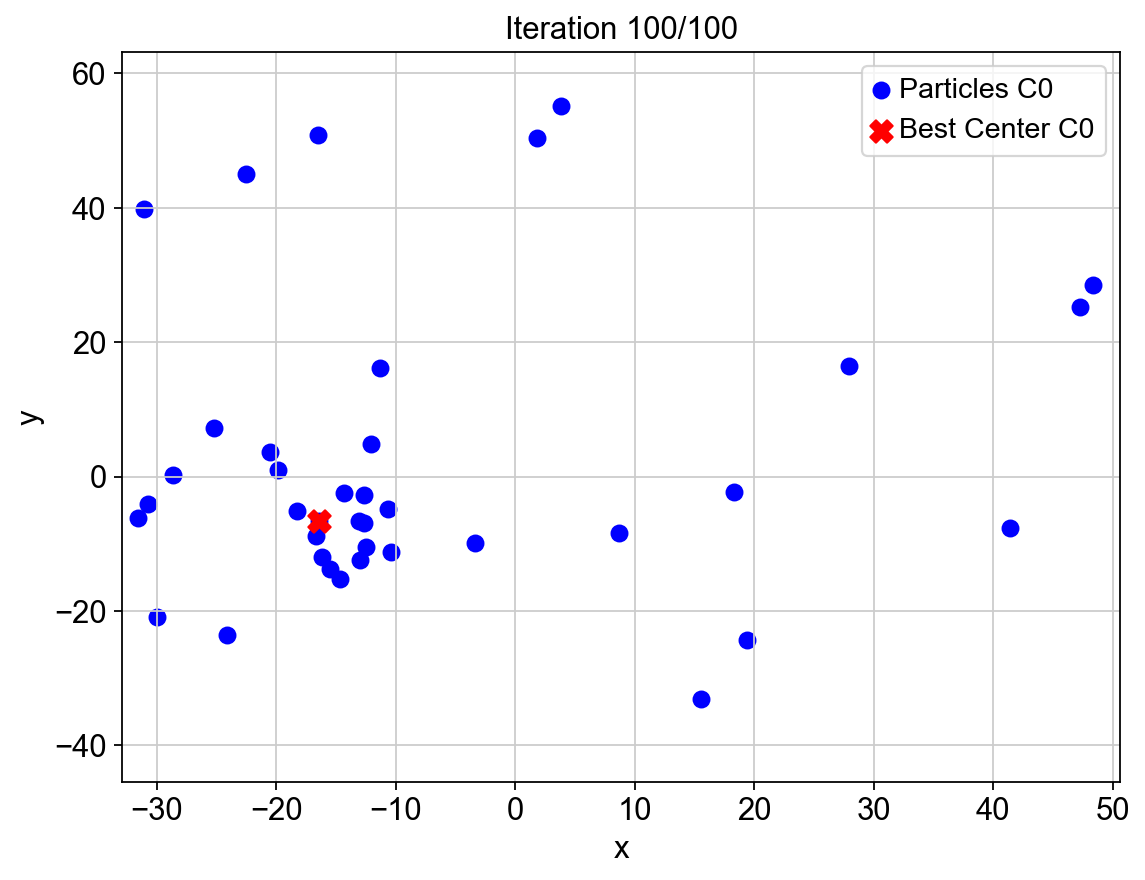

In [470]:
# To animate only cluster #0:
ani0 = SI.animate_best_center_history(input_data, pso_pos_history, pso_best_centers_history, center_idx=0)

# Save the animation as a GIF using imagemagick writer
ani0.save('../results/pbmc10k/pso/pso_animation_center0.gif', writer='imagemagick', fps=10)

### ABC

In [471]:
# Define the parameter search space for Bayesian Optimization
param_space_abc = [
    Integer(5, 50, name='n_food_sources'),  # Number of food sources
    Integer(5, 50, name='limit'),          # Limit for abandonment
    Integer(2, 10, name='n_clusters')      # Number of clusters
]

# Define the objective function for Bayesian Optimization
@use_named_args(param_space_abc)
def objective_function_abc(**params):
    n_food_sources = params['n_food_sources']
    limit = params['limit']
    n_clusters = params['n_clusters']
    
    print(f"Testing parameters: n_food_sources={n_food_sources}, limit={limit}, n_clusters={n_clusters}")
    
    # Run ABC with the given parameters
    abc_cost, abc_centers, abc_labels, _ = SI.run_abc(
        input_data, n_clusters=n_clusters, iters=100, n_food_sources=n_food_sources, limit=limit, record_history=False
    )
    
    # Calculate silhouette score
    score = silhouette_score(input_data, abc_labels)
    print(f"Silhouette Score: {score:.4f}")
    
    # Return the negative silhouette score (since Bayesian Optimization minimizes the objective)
    return -score

# Run Bayesian Optimization for ABC
print("Starting Bayesian Optimization for ABC parameters...")
result_abc = gp_minimize(
    func=objective_function_abc,  # Objective function
    dimensions=param_space_abc,   # Parameter space
    n_calls=30,                   # Number of evaluations
    random_state=42               # For reproducibility
)

# Extract the best parameters and score
best_params_abc = result_abc.x
best_score_abc = -result_abc.fun  # Convert back to positive silhouette score

print(f"\nBest Parameters for ABC: n_food_sources={best_params_abc[0]}, limit={best_params_abc[1]}, n_clusters={best_params_abc[2]}")
print(f"Best Silhouette Score for ABC: {best_score_abc:.4f}")


Starting Bayesian Optimization for ABC parameters...
Testing parameters: n_food_sources=41, limit=13, n_clusters=8
Silhouette Score: 0.4796
Testing parameters: n_food_sources=32, limit=25, n_clusters=3
Silhouette Score: 0.7344
Testing parameters: n_food_sources=26, limit=20, n_clusters=3
Silhouette Score: 0.7343
Testing parameters: n_food_sources=34, limit=8, n_clusters=8
Silhouette Score: 0.5650
Testing parameters: n_food_sources=47, limit=5, n_clusters=10
Silhouette Score: 0.4392
Testing parameters: n_food_sources=33, limit=33, n_clusters=2
Silhouette Score: 0.6722
Testing parameters: n_food_sources=6, limit=29, n_clusters=5
Silhouette Score: 0.5450
Testing parameters: n_food_sources=7, limit=49, n_clusters=4
Silhouette Score: 0.6859
Testing parameters: n_food_sources=9, limit=33, n_clusters=5
Silhouette Score: 0.4908
Testing parameters: n_food_sources=49, limit=26, n_clusters=9
Silhouette Score: 0.3606
Testing parameters: n_food_sources=5, limit=49, n_clusters=3
Silhouette Score: 0.

In [472]:
# Use the best parameters to run ABC
n_food_sources = best_params_abc[0]
limit = best_params_abc[1]
n_clusters = best_params_abc[2]

abc_cost, abc_centers, abc_labels, abc_history = SI.run_abc(
    input_data, n_clusters=n_clusters, iters=100, n_food_sources=n_food_sources, limit=limit, record_history=True
)

# Save the best results
results.loc["ABC"] = SI.calculate_clustering_scores(input_data, abc_labels)

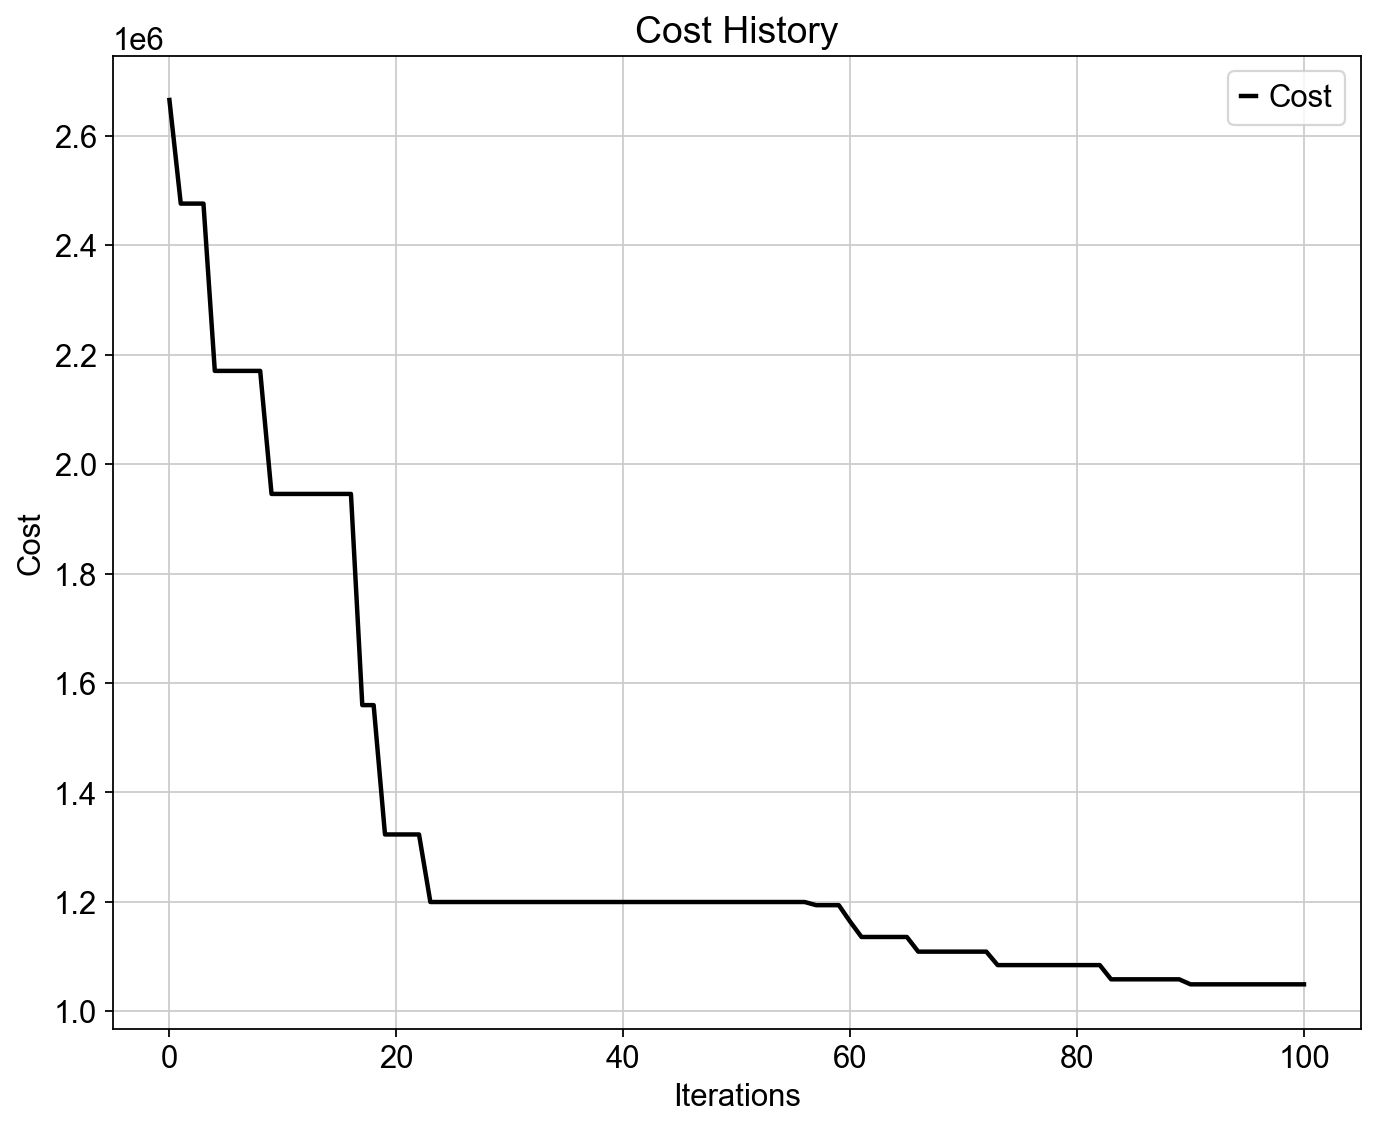

In [473]:
plot_cost_history(cost_history=abc_history["costs"])
plt.show()

2025-04-21 23:13:09,588 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-21 23:13:09,590 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


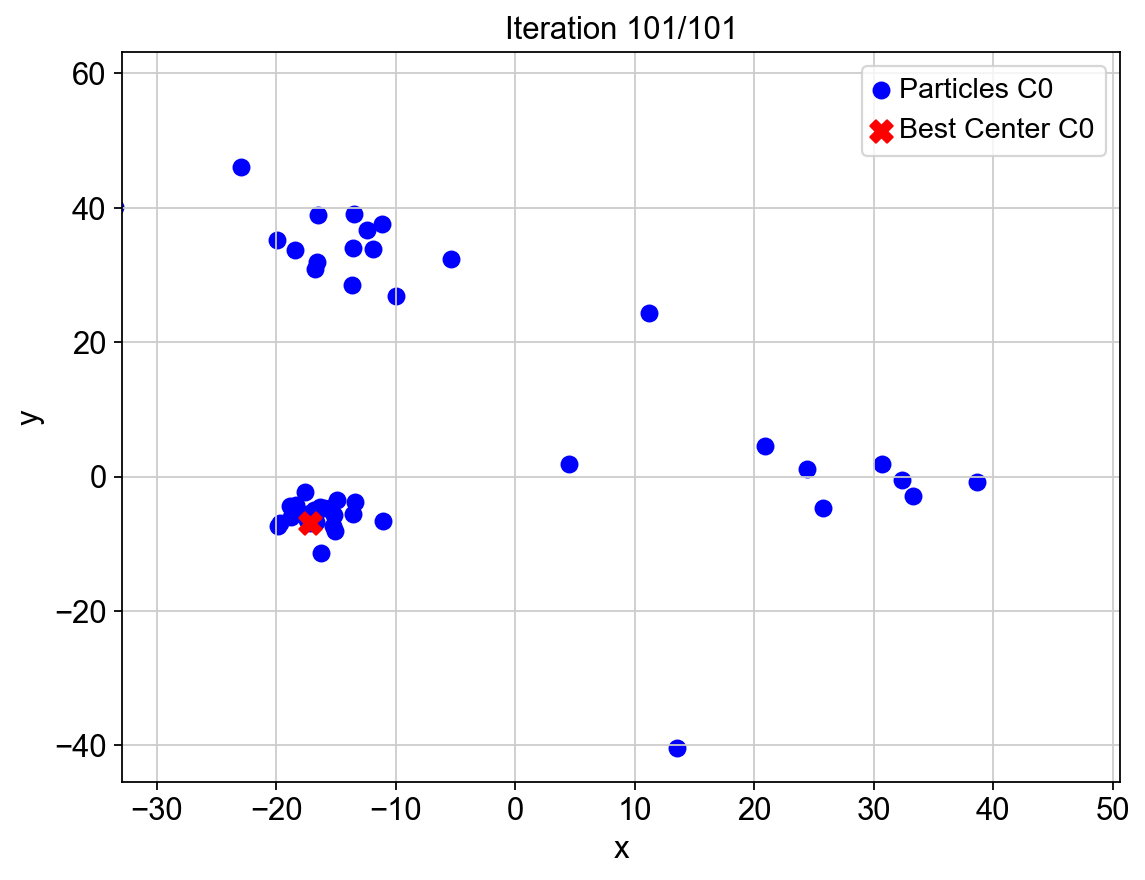

In [474]:
ani0 = SI.animate_best_center_history(input_data, abc_history["positions"], abc_history["best_centers"], center_idx=0)
ani0.save('../results/pbmc10k/abc/abc_animation_center0.gif', writer='imagemagick', fps=10)

### ACOR

In [475]:
# Define the parameter search space for Bayesian Optimization
param_space_acor = [
    Integer(10, 100, name='archive_size'),  # Size of the archive
    Integer(10, 100, name='ants'),         # Number of ants
    Real(0.1, 1.0, name='q'),              # Intensification factor
    Real(0.5, 1.0, name='xi'),             # Convergence factor
    Integer(2, 10, name='n_clusters')      # Number of clusters
]

# Define the objective function for Bayesian Optimization
@use_named_args(param_space_acor)
def objective_function_acor(**params):
    archive_size = params['archive_size']
    ants = params['ants']
    q = params['q']
    xi = params['xi']
    n_clusters = params['n_clusters']
    
    print(f"Testing parameters: archive_size={archive_size}, ants={ants}, q={q:.2f}, xi={xi:.2f}, n_clusters={n_clusters}")
    
    # Run ACOR with the given parameters
    acor_cost, acor_centers, acor_labels, _ = SI.run_acor(
        input_data, n_clusters=n_clusters, iters=100, archive_size=archive_size, ants=ants, q=q, xi=xi, record_history=False
    )
    
    # Calculate silhouette score
    score = silhouette_score(input_data, acor_labels)
    print(f"Silhouette Score: {score:.4f}")
    
    # Return the negative silhouette score (since Bayesian Optimization minimizes the objective)
    return -score

# Run Bayesian Optimization for ACOR
print("Starting Bayesian Optimization for ACOR parameters...")
result_acor = gp_minimize(
    func=objective_function_acor,  # Objective function
    dimensions=param_space_acor,   # Parameter space
    n_calls=30,                    # Number of evaluations
    random_state=42                # For reproducibility
)

# Extract the best parameters and score
best_params_acor = result_acor.x
best_score_acor = -result_acor.fun  # Convert back to positive silhouette score

print(f"\nBest Parameters for ACOR: archive_size={best_params_acor[0]}, ants={best_params_acor[1]}, q={best_params_acor[2]:.2f}, xi={best_params_acor[3]:.2f}, n_clusters={best_params_acor[4]}")
print(f"Best Silhouette Score for ACOR: {best_score_acor:.4f}")

Starting Bayesian Optimization for ACOR parameters...
Testing parameters: archive_size=82, ants=27, q=0.80, xi=0.80, n_clusters=6
Silhouette Score: 0.5530
Testing parameters: archive_size=19, ants=51, q=0.40, xi=0.57, n_clusters=7
Silhouette Score: 0.4793
Testing parameters: archive_size=15, ants=75, q=0.94, xi=0.50, n_clusters=10
Silhouette Score: 0.4475
Testing parameters: archive_size=66, ants=65, q=0.11, xi=0.51, n_clusters=6
Silhouette Score: 0.4902
Testing parameters: archive_size=46, ants=14, q=0.98, xi=0.62, n_clusters=3
Silhouette Score: 0.7324
Testing parameters: archive_size=66, ants=44, q=0.98, xi=0.73, n_clusters=9
Silhouette Score: 0.2701
Testing parameters: archive_size=71, ants=51, q=0.11, xi=0.97, n_clusters=7
Silhouette Score: 0.4777
Testing parameters: archive_size=45, ants=11, q=0.31, xi=0.62, n_clusters=7
Silhouette Score: 0.4447
Testing parameters: archive_size=65, ants=85, q=0.26, xi=0.70, n_clusters=3
Silhouette Score: 0.7344
Testing parameters: archive_size=78,

d:\Users\Luca\anaconda3\envs\bda_project\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(100), np.int64(100), 0.1, 1.0, np.int64(3)] before, using random point [np.int64(39), np.int64(74), 0.5228324362170177, 0.5954574172777443, np.int64(5)]
  warnings.warn(


Testing parameters: archive_size=39, ants=74, q=0.52, xi=0.60, n_clusters=5
Silhouette Score: 0.4938
Testing parameters: archive_size=100, ants=100, q=0.10, xi=1.00, n_clusters=2
Silhouette Score: 0.6722
Testing parameters: archive_size=100, ants=10, q=0.10, xi=1.00, n_clusters=3
Silhouette Score: 0.7325


d:\Users\Luca\anaconda3\envs\bda_project\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(100), np.int64(100), 0.1, 1.0, np.int64(3)] before, using random point [np.int64(22), np.int64(58), 0.4802470881457832, 0.5549342511852128, np.int64(5)]
  warnings.warn(


Testing parameters: archive_size=22, ants=58, q=0.48, xi=0.55, n_clusters=5
Silhouette Score: 0.5809

Best Parameters for ACOR: archive_size=51, ants=75, q=0.72, xi=0.84, n_clusters=3
Best Silhouette Score for ACOR: 0.7347


In [476]:

# Use the best parameters to run ACOR
archive_size = best_params_acor[0]
ants = best_params_acor[1]
q = best_params_acor[2]
xi = best_params_acor[3]
n_clusters = best_params_acor[4]

acor_cost, acor_centers, acor_labels, acor_history = SI.run_acor(
    input_data, n_clusters=n_clusters, iters=100, archive_size=archive_size, ants=ants, q=q, xi=xi, record_history=True
)

# Save the best results
results.loc["ACOR"] = SI.calculate_clustering_scores(input_data, acor_labels)


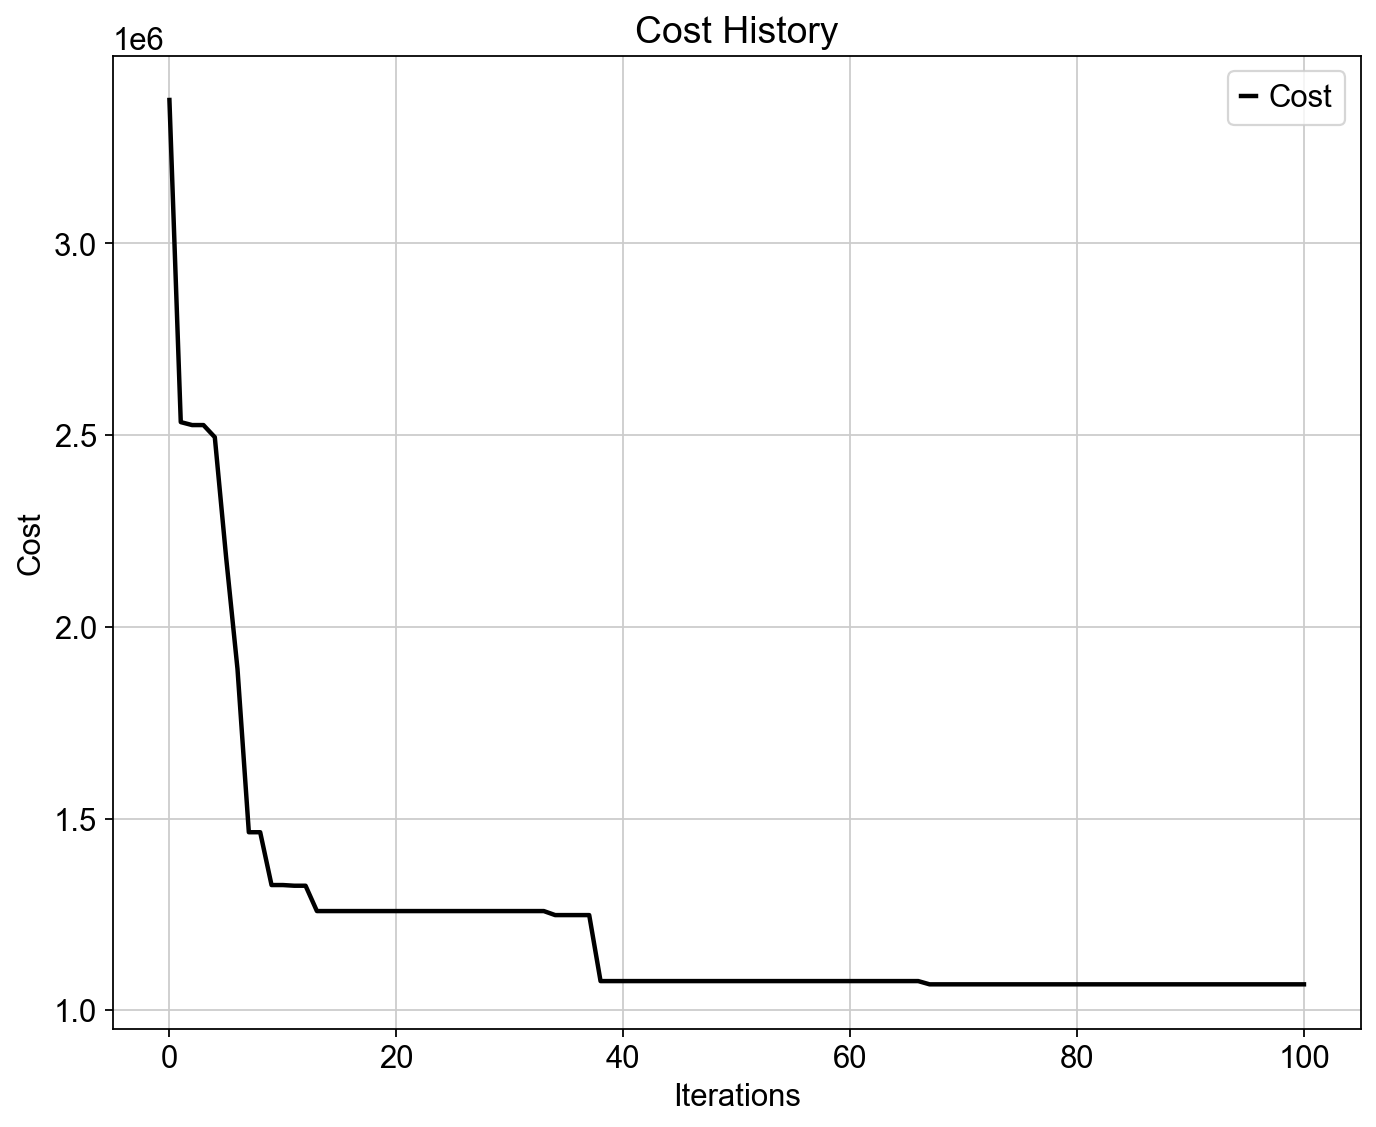

In [477]:
plot_cost_history(cost_history=acor_history["costs"])
plt.show()

2025-04-21 23:20:09,463 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-21 23:20:09,464 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


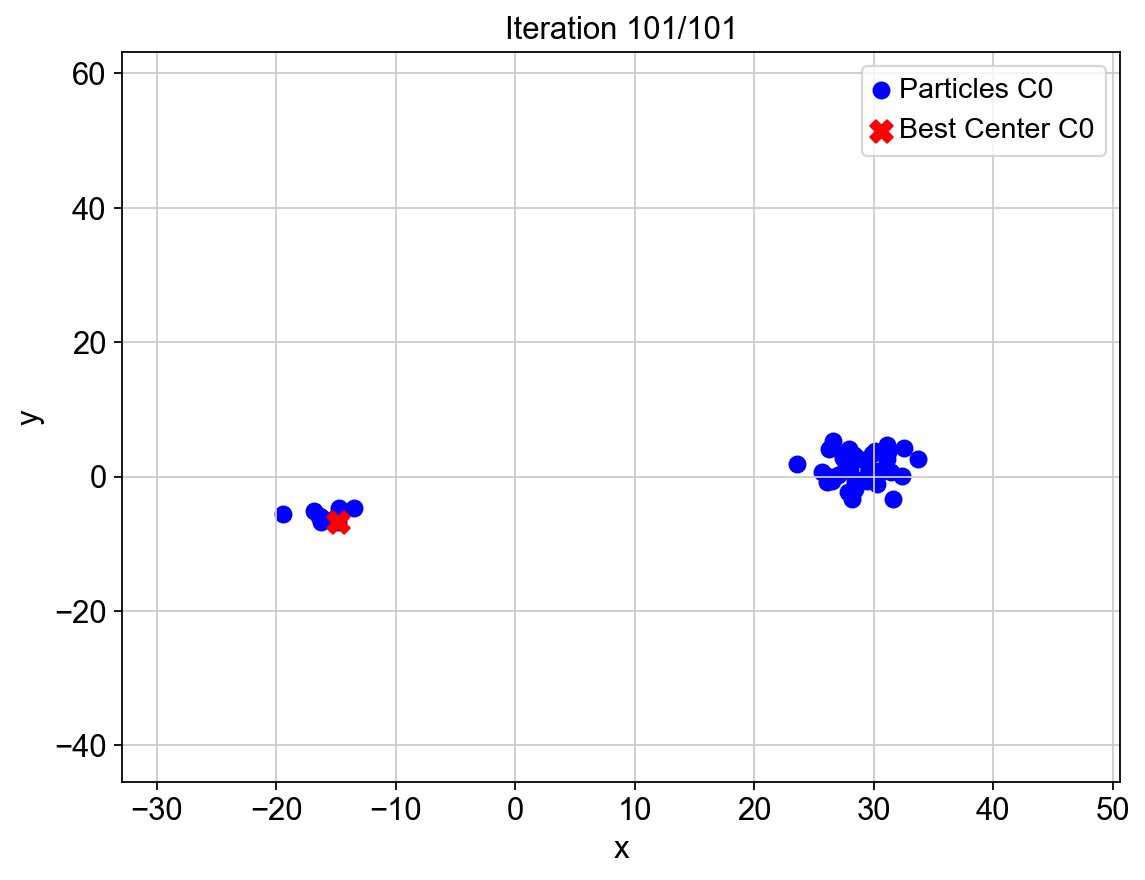

In [478]:
ani = SI.animate_best_center_history(input_data, acor_history["archives"], acor_history["best_centers"], center_idx=0)
ani.save('../results/pbmc10k/acor/acor_animation_center0.gif', writer='imagemagick', fps=10)

# Results

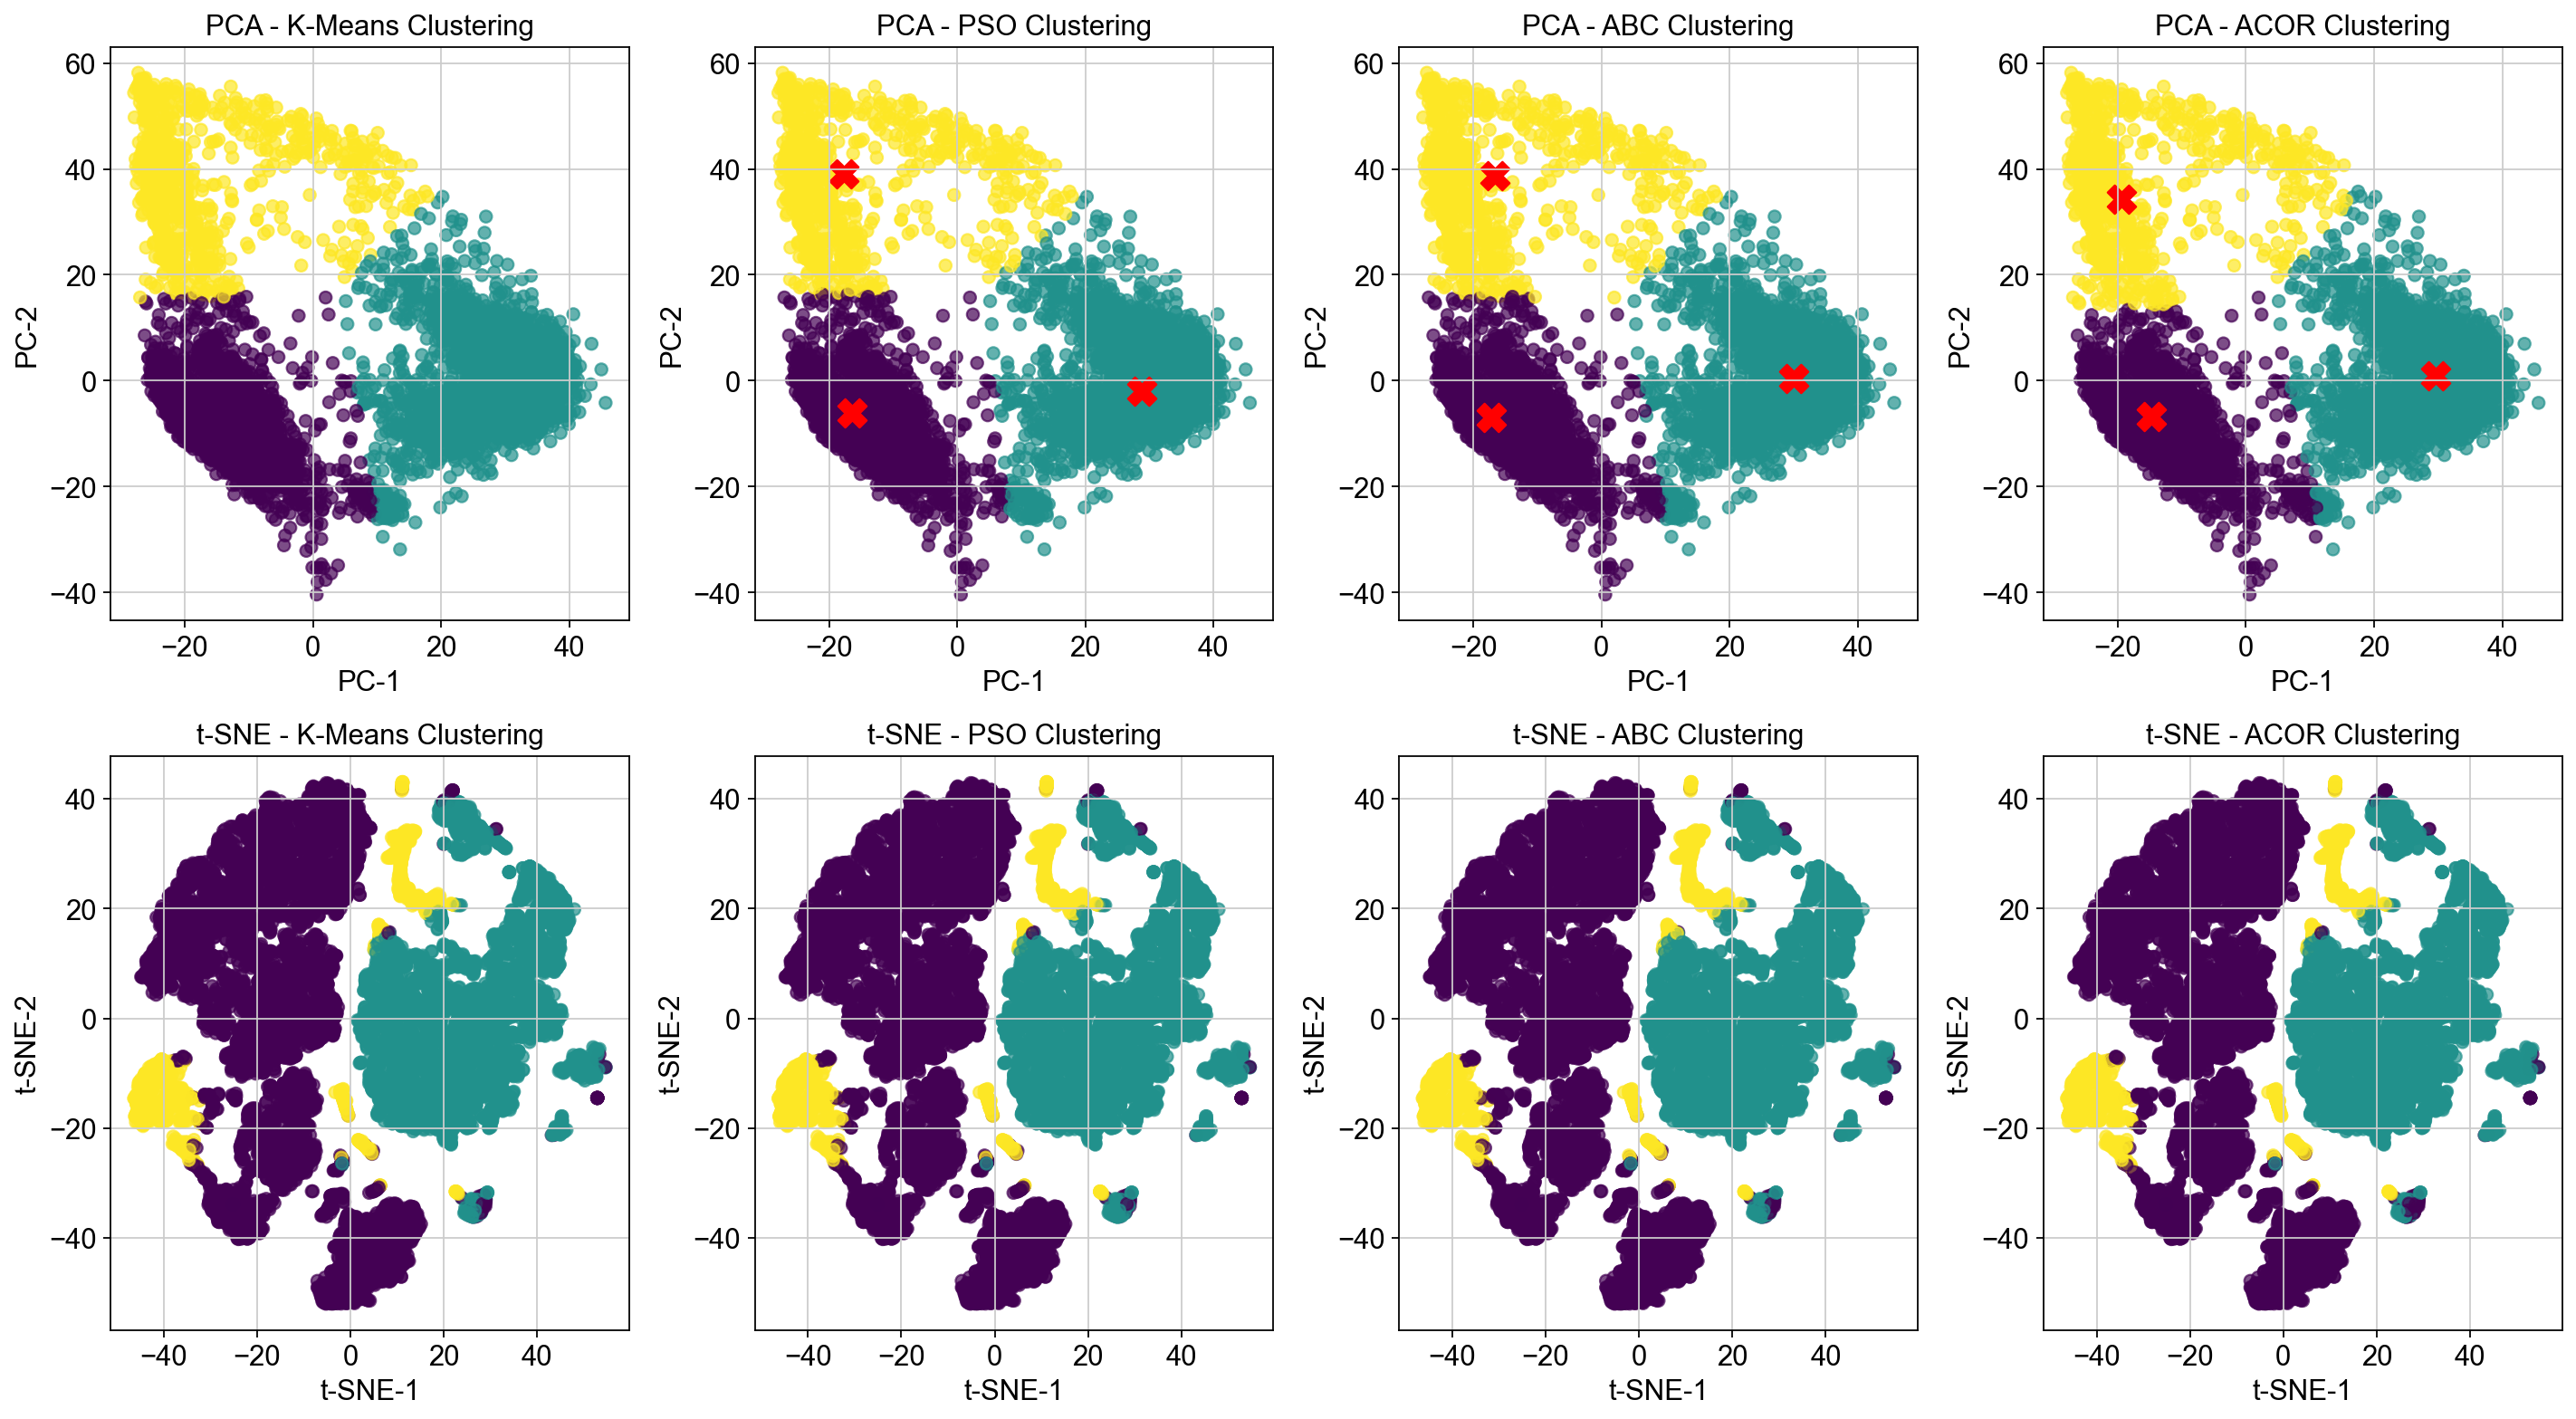

In [479]:
# -------------------------------
# 6. Visualization of Clustering Results
# -------------------------------
fig, axes = plt.subplots(2, 4, figsize=(18, 10))  # 2 rows, 4 columns

# Titles and data for PCA and t-SNE rows
titles = ["K-Means Clustering", "PSO Clustering", "ABC Clustering", "ACOR Clustering"]
cluster_labels = [kmeans_labels, pso_labels, abc_labels, acor_labels]
cluster_centers = [None, pso_centers, abc_centers, acor_centers]

# Plot PCA-based clustering (top row)
for i, ax in enumerate(axes[0]):
    plt.sca(ax)
    SI.plot_clusters(
        pca_proj_downl.drop(columns=["Barcode"]),
        cluster_labels[i],
        title=f"PCA - {titles[i]}",
        centers=cluster_centers[i],
        x_label="PC-1",
        y_label="PC-2"
    )

# Plot t-SNE-based clustering (bottom row)
for i, ax in enumerate(axes[1]):
    plt.sca(ax)
    SI.plot_clusters(
        tsne_proj_downl.drop(columns=["Barcode"]),
        cluster_labels[i],
        title=f"t-SNE - {titles[i]}",
        x_label="t-SNE-1",
        y_label="t-SNE-2"
    )

# Adjust layout
plt.tight_layout()
plt.show()

In [480]:
# Save clustering results to CSV files
results.to_csv("../results/pbmc10k/clustering_results.csv", index=True)
results.head()

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means,0.734,0.429,36096.6
PSO,0.735,0.429,36041.2
ABC,0.734,0.431,36091.5
ACOR,0.733,0.434,35996.6
